# Calculating gradients 

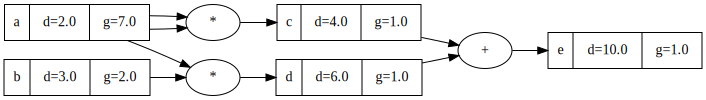

In [19]:
from graph import draw
from value import Value

a = Value(2.0); a.label = 'a'
b = Value(3.0); b.label = 'b'
c = a * a; c.label = 'c'
d = a * b; d.label = 'd'
e = c + d; e.label = 'e'

# e = a^2 + ab
e.backward()

# e(a) = a^2 + 3a
# de/da = 2a + 3 = 7
# e(b) = 2^2 + 2b
# de/db = 2
draw(e)

# Cool nonlinear functions we can apply to neurons

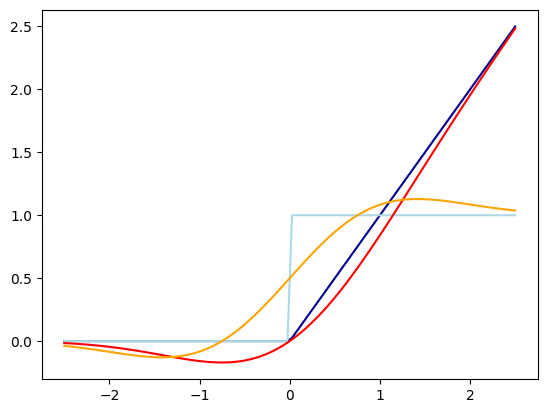

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from value import Value

def plot_data(domain, operation):
    return [xs, [operation(Value(x)).data for x in domain]]

def plot_grads(domain, operation):
    grads = []
    for x in domain:
        val = Value(x)
        operation(val).backward()
        grads.append(val.grad)
    return [xs, grads]

xs = np.linspace(-2.5, 2.5, 100)

# daniel
relu = lambda v: v.relu()
plt.plot(*plot_data(xs, relu), color='darkblue')
plt.plot(*plot_grads(xs, relu), color='lightblue')

# the cooler daniel
gelu = lambda v: v.gelu()
plt.plot(*plot_data(xs, gelu), color='red')
plt.plot(*plot_grads(xs, gelu), color='orange')

plt.show()

# Learning a super-simple dataset 

In [22]:
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_second_half_roughly.ipynb
XS = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
YS = [1.0, -1.0, -1.0, 1.0]
IN_LAYER = 3
HIDDEN_LAYERS = [4, 4]
OUT_LAYER = 1

FAST_LEARN_CYCLES = 50
FAST_LEARN_RATE = 0.1

SLOW_LEARN_CYCLES = 1000
SLOW_LEARN_RATE = 0.005

## Using jangrad

oh no, the learning curve is all weird :((


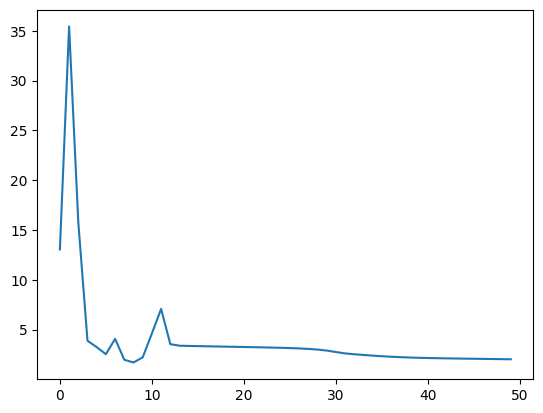

just use a lower learning rate with more cycles and it smooths out


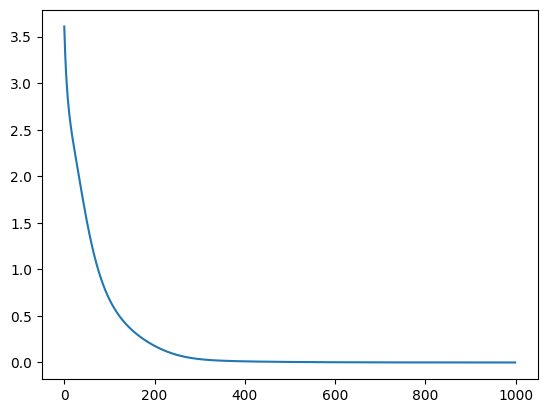

In [23]:
from net import MLP
import matplotlib.pyplot as plt

print("oh no, the learning curve is all weird :((")
n = MLP(IN_LAYER, HIDDEN_LAYERS + [OUT_LAYER])
losses = [n.learn(XS, YS, FAST_LEARN_RATE).data for _ in range(FAST_LEARN_CYCLES)]
plt.plot(range(FAST_LEARN_CYCLES), losses)
plt.show()

print("just use a lower learning rate with more cycles and it smooths out")
n = MLP(IN_LAYER, HIDDEN_LAYERS + [OUT_LAYER])
losses = [n.learn(XS, YS, SLOW_LEARN_RATE).data for _ in range(SLOW_LEARN_CYCLES)]
plt.plot(range(SLOW_LEARN_CYCLES), losses)
plt.show()

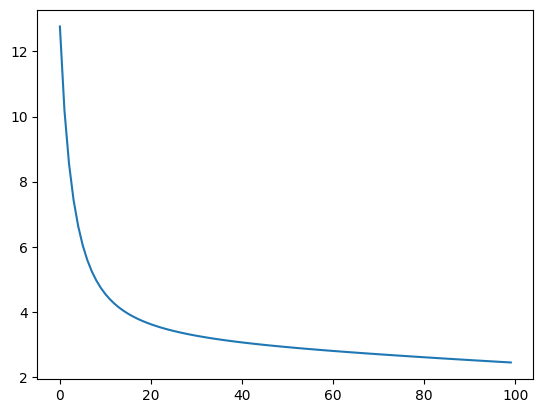

In [15]:
from net import MLP
import matplotlib.pyplot as plt

# one last thing: sometimes it gets stuck when loss is exactly 4.0
# TODO: investigate
learn_cycles = 100
for _ in range(learn_cycles):
    n = MLP(IN_LAYER, HIDDEN_LAYERS + [OUT_LAYER])
    losses = [n.learn(XS, YS, SLOW_LEARN_RATE).data for _ in range(learn_cycles)]
    if abs(losses[-1] - 4.0) < 0.1:
        break
plt.plot(range(learn_cycles), losses)
plt.show()

## Using PyTorch

pytorch also works with a much faster learning rate


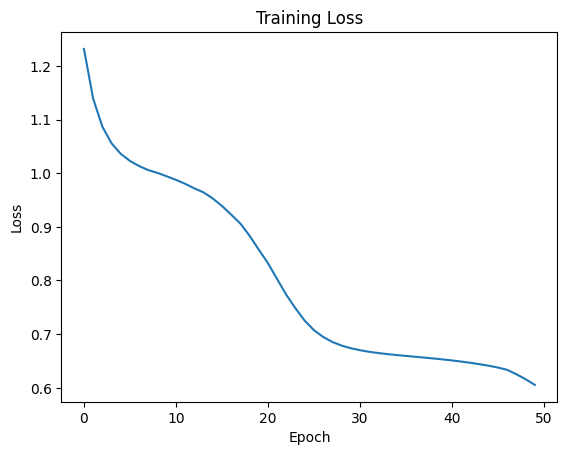

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:  # Add activation for hidden layers
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Inputs and targets
xs = torch.tensor(XS, dtype=torch.float32)
ys = torch.tensor(YS, dtype=torch.float32).view(-1, 1)

# Initialize the model
n = MLP(IN_LAYER, HIDDEN_LAYERS, OUT_LAYER)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(n.parameters(), lr=FAST_LEARN_RATE)

# Training loop
losses = []
for epoch in range(FAST_LEARN_CYCLES):
    # Forward pass
    outputs = n(xs)
    loss = criterion(outputs, ys)
    losses.append(loss.item())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    # print(f'{epoch:02}: {loss.item():.2f} {[output.item() for output in outputs]}')

# Plot the loss
print("pytorch also works with a much faster learning rate")
plt.plot(range(FAST_LEARN_CYCLES), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


## Using Andrew Kaparthy's micrograd

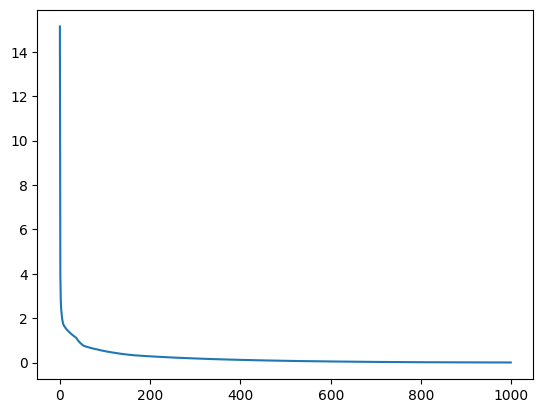

In [18]:
from micrograd.engine import Value
from micrograd.nn import MLP
import matplotlib.pyplot as plt

n = MLP(IN_LAYER, HIDDEN_LAYERS + [OUT_LAYER])

def loss():
    total = Value(0.0)
    for ins, des in zip(XS, YS):
        out = n(ins)
        total += (out - des)**2
    return total

losses = []
for k in range(SLOW_LEARN_CYCLES):
    # forward
    total_loss = loss()
    # backward
    n.zero_grad()
    total_loss.backward()
    losses.append(total_loss.data)
    
    # update (sgd)
    learning_rate = SLOW_LEARN_RATE
    for p in n.parameters():
        p.data -= learning_rate * p.grad
    
    # print(f"step {k} loss {total_loss.data}")

plt.plot(range(SLOW_LEARN_CYCLES), losses)
plt.show()